In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import os
import dlib
import json
import numpy as np
from torchvision import transforms
from PIL import Image

c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Dataset**

In [ ]:
import os
import torch
import numpy as np
import dlib
import cv2
from tqdm import tqdm

def compute_landmark_stats(pt_folder, predictor_path):
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictor_path)

    all_features = []

    pt_files = [os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')]

    for pt_file in tqdm(pt_files, desc="Menghitung fitur semua video"):
        data = torch.load(pt_file)
        frames = data['frames']
        d1s, d2s, d3s, d4s, d5s, d6s, ears = [], [], [], [], [], [], []
        blink_count, consec = 0, 0
        EAR_THRESH = 0.3
        EAR_CONSEC = 3

        for frame in frames:
            img = (frame.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            faces = detector(gray)
            if len(faces) == 0:
                continue

            shape = predictor(gray, faces[0])
            pts = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

            d1s.append(np.linalg.norm(np.array(pts[36]) - np.array(pts[39])))
            d2s.append(np.linalg.norm(np.array(pts[42]) - np.array(pts[45])))
            d3s.append(np.linalg.norm(np.array(pts[61]) - np.array(pts[67])))
            d4s.append(np.linalg.norm(np.array(pts[48]) - np.array(pts[54])))
            d5s.append(np.linalg.norm(np.array(pts[31]) - np.array(pts[35])))
            d6s.append(np.linalg.norm(np.array(pts[27]) - np.array(pts[30])))

            left_eye = [pts[i] for i in range(36, 42)]
            right_eye = [pts[i] for i in range(42, 48)]
            def ear(eye):
                A = np.linalg.norm(np.array(eye[1]) - np.array(eye[5]))
                B = np.linalg.norm(np.array(eye[2]) - np.array(eye[4]))
                C = np.linalg.norm(np.array(eye[0]) - np.array(eye[3]))
                return (A + B) / (2.0 * C)

            e = (ear(left_eye) + ear(right_eye)) / 2.0
            ears.append(e)
            if e < EAR_THRESH:
                consec += 1
            else:
                if consec >= EAR_CONSEC:
                    blink_count += 1
                consec = 0

        if len(d1s) == 0:
            continue  # Skip jika tidak ada wajah

        features = [
            np.mean(d1s), np.mean(d2s),
            np.mean(d3s), np.mean(d4s),
            np.mean(d5s), np.mean(d6s),
            blink_count
        ]
        all_features.append(features)

    all_features = np.array(all_features)
    features_mean = all_features.mean(axis=0)
    features_std = all_features.std(axis=0)

    print("Mean:", features_mean)
    print("Std :", features_std)

    # Simpan
    np.save("features_mean.npy", features_mean)
    np.save("features_std.npy", features_std)

    return features_mean, features_std


In [ ]:
from torch.utils.data import Dataset
import os
import torch
import numpy as np
import dlib
import cv2

def euclidean(p1, p2):
    return np.linalg.norm(np.array(p1) - np.array(p2))

def compute_ear(eye):
    A = euclidean(eye[1], eye[5])
    B = euclidean(eye[2], eye[4])
    C = euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

class ProcessedLandmarkFeatureDataset(Dataset):
    def __init__(self, pt_folder, predictor_path, features_mean, features_std):
        self.pt_files = sorted([
            os.path.join(pt_folder, f) for f in os.listdir(pt_folder) if f.endswith('.pt')
        ])
        self.detector = dlib.get_frontal_face_detector()
        self.predictor = dlib.shape_predictor(predictor_path)
        self.features_mean = features_mean
        self.features_std = features_std

    def __len__(self):
        return len(self.pt_files)

    def __getitem__(self, idx):
        data = torch.load(self.pt_files[idx])
        
        filepath = self.pt_files[idx]
        filename = os.path.basename(filepath)
        
        frames = data['frames']  # (T, C, H, W)
        label = data['label']

        d1s, d2s, d3s, d4s, d5s, d6s, ears = [], [], [], [], [], [], []
        blink_count, consec = 0, 0
        EAR_THRESH = 0.3
        EAR_CONSEC = 3

        for frame in frames:
            img = (frame.permute(1, 2, 0).numpy() * 255).astype(np.uint8)  # (H, W, C)
            gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            faces = self.detector(gray)

            if len(faces) == 0:
                continue

            shape = self.predictor(gray, faces[0])
            pts = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

            # Titik - titik landmark
            d1s.append(euclidean(pts[36], pts[39]))
            d2s.append(euclidean(pts[42], pts[45]))
            d3s.append(euclidean(pts[61], pts[67]))
            d4s.append(euclidean(pts[48], pts[54]))
            d5s.append(euclidean(pts[31], pts[35]))
            d6s.append(euclidean(pts[27], pts[30]))

            # rasio kedipan mata
            left_eye = [pts[i] for i in range(36, 42)]
            right_eye = [pts[i] for i in range(42, 48)]
            ear = (compute_ear(left_eye) + compute_ear(right_eye)) / 2.0
            ears.append(ear)

            # cek dari threshold 0.3
            if ear < EAR_THRESH:
                consec += 1
            else:
                if consec >= EAR_CONSEC:
                    blink_count += 1
                consec = 0

        features = np.array([
                np.mean(d1s), np.mean(d2s),
                np.mean(d3s), np.mean(d4s),
                np.mean(d5s), np.mean(d6s),
                blink_count
            ], dtype=np.float32)

        features = (features - self.features_mean) / (self.features_std + 1e-8)
        
        return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename

In [ ]:
from torch.utils.data import DataLoader, random_split

# Ganti dengan path folder .pt kamu
pt_folder = 'Dataset Deepfake Preprocessed/Preprocessed Wajah'
predictor_path = 'shape_predictor_68_face_landmarks.dat'

In [ ]:
features_mean, features_std = compute_landmark_stats(pt_folder, predictor_path)

Menghitung fitur semua video: 100%|██████████| 335/335 [01:18<00:00,  4.29it/s]

Mean: [37.32880012 37.96294455  6.3791358  83.21520784 45.33583882 39.59833639
  0.39329268]
Std : [2.94754343 2.76075389 2.91198973 6.8796676  4.84871233 6.41547178
 0.85587148]


TypeError: ProcessedLandmarkFeatureDataset.__init__() takes 3 positional arguments but 5 were given

In [4]:
features_mean = np.load("features_mean.npy")
features_std = np.load("features_std.npy")

In [5]:
# Buat full dataset
full_dataset = ProcessedLandmarkFeatureDataset(pt_folder, predictor_path, features_mean, features_std)

# Split 80% training, 20% validation
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Buat DataLoader
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)

In [31]:
for frames, features, label in train_loader:
    print("Frames:", frames.shape)        # (B, T, C, H, W)
    print("Landmark features:", features) # (B, 7)
    print("Label:", label)                # (B,)
    break

C:\Users\krist\AppData\Local\Temp\ipykernel_416780\2767011841.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Frames: torch.Size([4, 50, 3, 224, 224])
Landmark features: tensor([[ 0.2709,  0.3840, -0.9120, -0.3051,  0.1841,  1.1820,  1.8773],
        [-0.6563,  0.2524, -1.4708, -0.1593, -1.0758,  0.0772,  3.0457],
        [-0.2803, -0.2774, -0.3458, -0.1959,  1.4414,  1.8818, -0.4595],
        [ 1.1956,  1.1968,  0.5146,  0.1683, -0.4718,  0.0721, -0.4595]])
Label: tensor([1, 0, 0, 0])


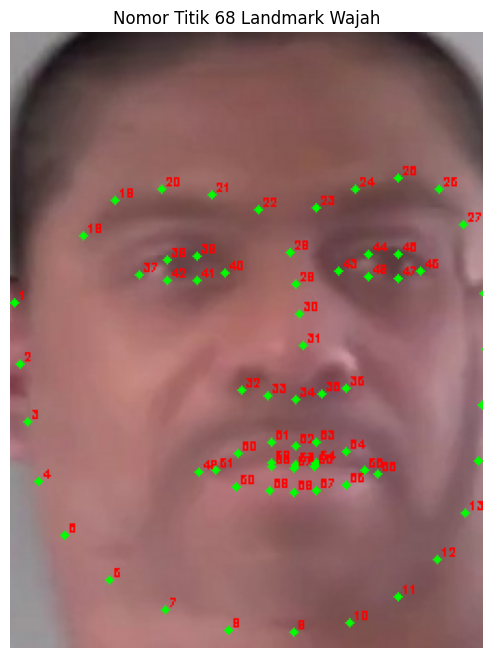

In [62]:
import cv2
import dlib
import matplotlib.pyplot as plt

# Load model dan gambar
predictor_path = "shape_predictor_68_face_landmarks.dat"
image_path = "Dataset/face_frames/abhlupreiy/face_0_frame_0000.jpg"  # Gambar wajah apa pun

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

img = cv2.imread(image_path)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = detector(gray)

# Ambil titik dan tampilkan nomor
for face in faces:
    shape = predictor(gray, face)
    for i in range(68):
        x = shape.part(i).x
        y = shape.part(i).y
        cv2.circle(img, (x, y), 2, (0, 255, 0), -1)
        cv2.putText(img, str(i+1), (x+2, y-2), cv2.FONT_HERSHEY_SIMPLEX, 0.2, (0, 0, 255), 1)

# Tampilkan
plt.figure(figsize=(10, 8))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Nomor Titik 68 Landmark Wajah")
plt.show()


**Load Model**

In [ ]:
# CNN Model
class CNNFeatureExtractor(nn.Module):
    def __init__(self):
        super(CNNFeatureExtractor, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
        )
        self.flatten = nn.Flatten()
        self.fc_layers = nn.Sequential(
            nn.Linear(64 * 28 * 28, 128),  # 224 / 8 = 28
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.ReLU()
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.fc_layers(x)
        return x

In [ ]:
# MLP Model
class MLPFeatureExtractor(nn.Module):
    def __init__(self, input_size=7):
        super(MLPFeatureExtractor, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.fc(x)

In [ ]:
# Model CNN-MLP
class DeepfakeDetector(nn.Module):
    def __init__(self, mlp_input_size=7):
        super(DeepfakeDetector, self).__init__()
        self.cnn = CNNFeatureExtractor()
        self.mlp = MLPFeatureExtractor(input_size=mlp_input_size)
        self.classifier = nn.Sequential(
            nn.Linear(64 + 32, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )
    
    def forward(self, image, features):
        B, T, C, H, W = image.shape
        x = image.view(B * T, C, H, W)      # Flatten batch and time
        cnn_out = self.cnn(x)               # (B*T, 64)
        cnn_out = cnn_out.view(B, T, -1)    # (B, T, 64)
        cnn_out = cnn_out.mean(dim=1)       # (B, 64)

        mlp_out = self.mlp(features)        # (B, 32)
        combined = torch.cat((cnn_out, mlp_out), dim=1)  # (B, 96)
        return self.classifier(combined)    # (B, 1)

In [35]:
model = DeepfakeDetector()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Optimizer dan loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, landmarks, labels in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(frames, landmarks)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs >= 0.5).long()
        labels = labels.long()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, landmarks, labels in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            landmarks = landmarks.to(device)
            labels = labels.to(device)
            labels = labels.float()

            outputs = model(frames, landmarks)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs >= 0.5).long()
            labels = labels.long()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/MLP-CNN_LR1e-4.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_416780\2767011841.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


Epoch [1/40] Train Loss: 0.6968 | Train Acc: 0.4701 | Val Loss: 0.7025 | Val Acc: 0.5075
Epoch [2/40] Train Loss: 0.6822 | Train Acc: 0.6007 | Val Loss: 0.6988 | Val Acc: 0.4478
Epoch [3/40] Train Loss: 0.6586 | Train Acc: 0.6604 | Val Loss: 0.6844 | Val Acc: 0.5672
Epoch [4/40] Train Loss: 0.6430 | Train Acc: 0.6567 | Val Loss: 0.7215 | Val Acc: 0.4776
Epoch [5/40] Train Loss: 0.6253 | Train Acc: 0.6604 | Val Loss: 0.6920 | Val Acc: 0.4776
Epoch [6/40] Train Loss: 0.5985 | Train Acc: 0.6978 | Val Loss: 0.7405 | Val Acc: 0.4776
Epoch [7/40] Train Loss: 0.5869 | Train Acc: 0.6530 | Val Loss: 0.6641 | Val Acc: 0.5821
Epoch [8/40] Train Loss: 0.5274 | Train Acc: 0.7649 | Val Loss: 0.6777 | Val Acc: 0.5075
Epoch [9/40] Train Loss: 0.4856 | Train Acc: 0.7612 | Val Loss: 0.6458 | Val Acc: 0.5970
Epoch [10/40] Train Loss: 0.4684 | Train Acc: 0.7799 | Val Loss: 0.6470 | Val Acc: 0.5672
Epoch [11/40] Train Loss: 0.4406 | Train Acc: 0.7761 | Val Loss: 0.6607 | Val Acc: 0.6119
Epoch [12/40] Train

In [39]:
print(best_val_loss)

0.45634552258164135


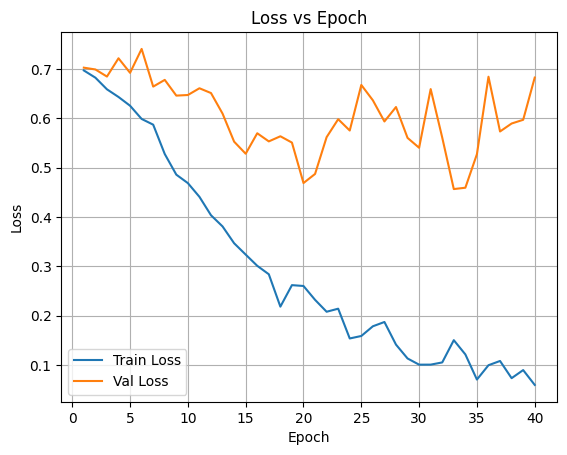

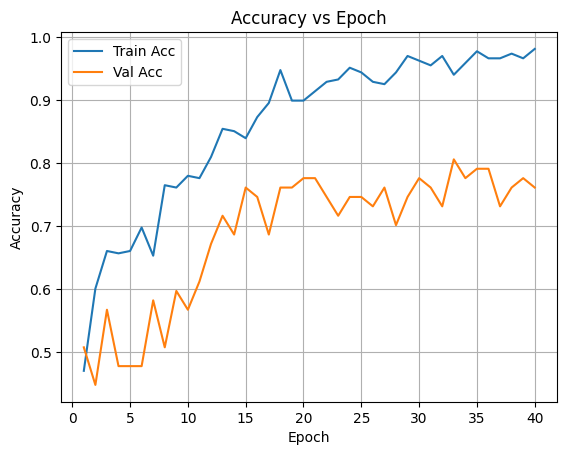

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_416780\2923494478.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename


aabyjxwqyo.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
chj

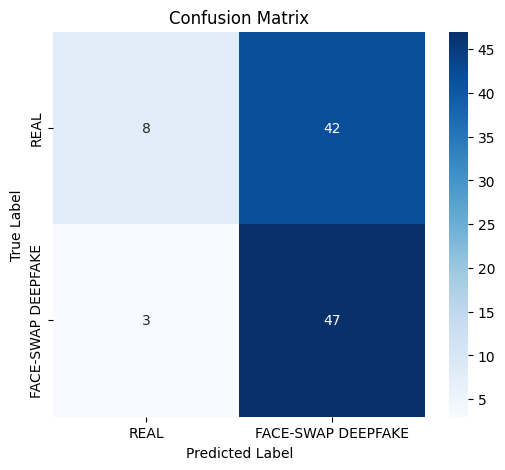


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.73      0.16      0.26        50
FACE-SWAP DEEPFAKE       0.53      0.94      0.68        50

          accuracy                           0.55       100
         macro avg       0.63      0.55      0.47       100
      weighted avg       0.63      0.55      0.47       100


📈 AUC Score: 0.5460


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


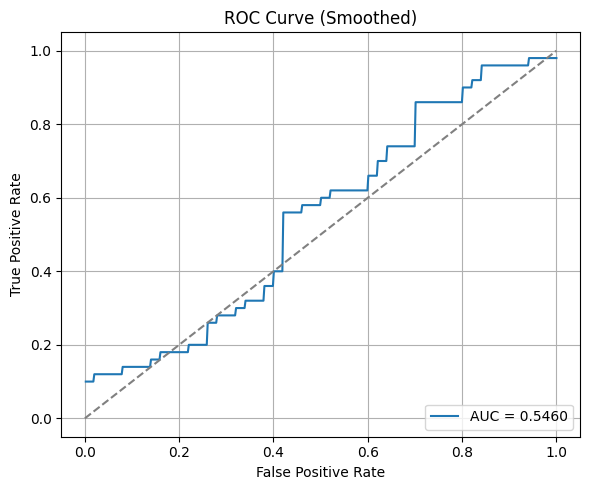

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeDetector()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/MLP-CNN_LR1e-4.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
predictor_path = "shape_predictor_68_face_landmarks.dat"

# Load model
model = load_model(model_path)

# Load dataset dan loader
test_dataset = ProcessedLandmarkFeatureDataset(pt_folder, predictor_path, features_mean, features_std)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Inference loop
for frames, features, labels, filenames in test_loader:
    frames = frames.to(device)  # (1, T, C, H, W)
    features = features.to(device).float()
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(frames, features).squeeze(1)
        probs = outputs.cpu().numpy()[0]              # scalar
        predicted = int(probs >= 0.5)                 # threshold
        probs_class1.append(probs)                    # DEEPFAKE prob

    true_label = labels.item()
    filename = filenames[0]
    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / len(true_labels) if true_labels else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{len(true_labels)})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score & ROC Curve
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")


**Coba Learning Rate 1e-5**

In [ ]:
model = DeepfakeDetector()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Optimizer dan loss function
# Ganti learning rate menjadi 0.00001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.BCELoss()

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, landmarks, labels, filenames in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(frames, landmarks)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs >= 0.5).long()
        labels = labels.long()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, landmarks, labels, filenames in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            landmarks = landmarks.to(device)
            labels = labels.to(device)
            labels = labels.float()

            outputs = model(frames, landmarks)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs >= 0.5).long()
            labels = labels.long()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/MLP-CNN_LR1e-5.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_468492\2923494478.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename


Epoch [1/40] Train Loss: 0.6867 | Train Acc: 0.5634 | Val Loss: 0.7105 | Val Acc: 0.4030
Epoch [2/40] Train Loss: 0.6734 | Train Acc: 0.5970 | Val Loss: 0.7168 | Val Acc: 0.4776
Epoch [3/40] Train Loss: 0.6678 | Train Acc: 0.6381 | Val Loss: 0.7038 | Val Acc: 0.4328
Epoch [4/40] Train Loss: 0.6643 | Train Acc: 0.6418 | Val Loss: 0.6951 | Val Acc: 0.4776
Epoch [5/40] Train Loss: 0.6510 | Train Acc: 0.6828 | Val Loss: 0.6877 | Val Acc: 0.4627
Epoch [6/40] Train Loss: 0.6334 | Train Acc: 0.7015 | Val Loss: 0.6915 | Val Acc: 0.4478
Epoch [7/40] Train Loss: 0.6386 | Train Acc: 0.7127 | Val Loss: 0.6796 | Val Acc: 0.4627
Epoch [8/40] Train Loss: 0.6248 | Train Acc: 0.6903 | Val Loss: 0.6672 | Val Acc: 0.5522
Epoch [9/40] Train Loss: 0.6090 | Train Acc: 0.7612 | Val Loss: 0.6858 | Val Acc: 0.4627
Epoch [10/40] Train Loss: 0.6052 | Train Acc: 0.7425 | Val Loss: 0.6232 | Val Acc: 0.6716
Epoch [11/40] Train Loss: 0.5982 | Train Acc: 0.7351 | Val Loss: 0.6478 | Val Acc: 0.5373
Epoch [12/40] Train

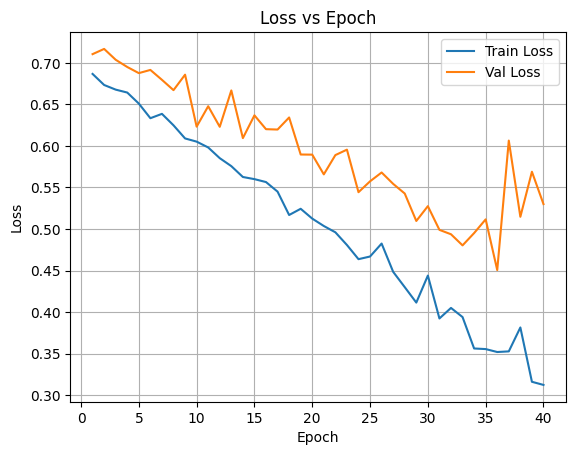

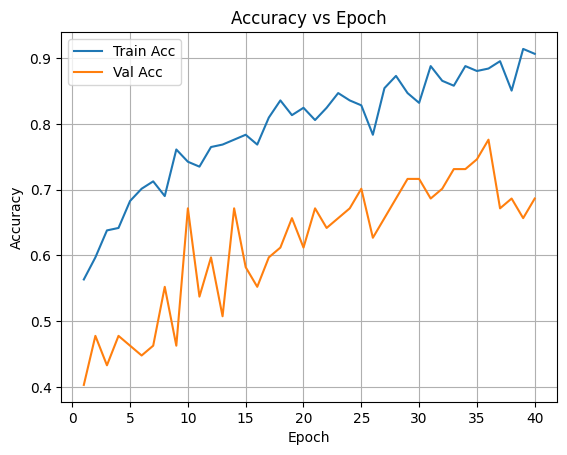

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_468492\2923494478.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename


aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = REAL, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = REAL, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bqwwkjlmgv.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = REAL, True = REAL
chnbexdyhq.pt: Predicted = REAL, True = RE

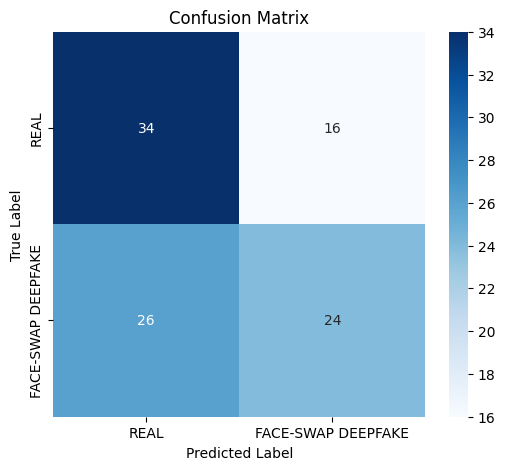


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.57      0.68      0.62        50
FACE-SWAP DEEPFAKE       0.60      0.48      0.53        50

          accuracy                           0.58       100
         macro avg       0.58      0.58      0.58       100
      weighted avg       0.58      0.58      0.58       100


📈 AUC Score: 0.6200


c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:701: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\krist\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\interpolate\_interpolate.py:704: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


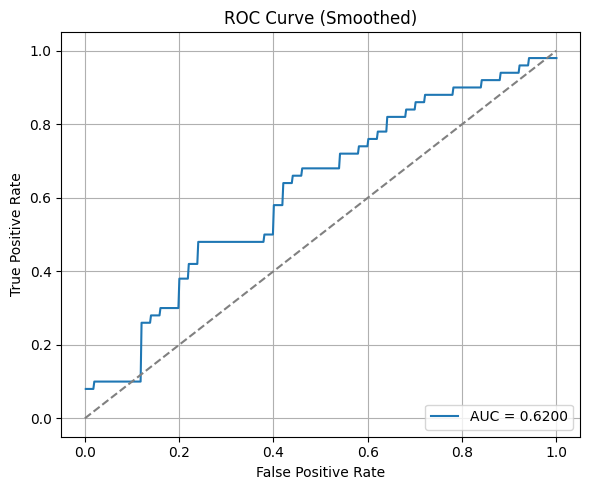

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeDetector()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/MLP-CNN_LR1e-5.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
predictor_path = "shape_predictor_68_face_landmarks.dat"

# Load model
model = load_model(model_path)

# Load dataset dan loader
test_dataset = ProcessedLandmarkFeatureDataset(pt_folder, predictor_path, features_mean, features_std)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Inference loop
for frames, features, labels, filenames in test_loader:
    frames = frames.to(device)  # (1, T, C, H, W)
    features = features.to(device).float()
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(frames, features).squeeze(1)
        probs = outputs.cpu().numpy()[0]              # scalar
        predicted = int(probs >= 0.5)                 # threshold
        probs_class1.append(probs)                    # DEEPFAKE prob

    true_label = labels.item()
    filename = filenames[0]
    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / len(true_labels) if true_labels else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{len(true_labels)})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score & ROC Curve
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")


**Coba Learning Rate 1e-3**

In [ ]:
model = DeepfakeDetector()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# Optimizer dan loss function
# Ganti learning rate menjadi 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

In [ ]:
# Log
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 40
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Training
    for frames, landmarks, labels, filenames in train_loader:
        frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
        landmarks = landmarks.to(device)
        labels = labels.to(device)
        labels = labels.float()

        optimizer.zero_grad()
        outputs = model(frames, landmarks)
        outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * frames.size(0)
        predicted = (outputs >= 0.5).long()
        labels = labels.long()
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    train_acc = total_correct / total_samples
    train_loss = running_loss / total_samples

    # Validasi
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for frames, landmarks, labels, filenames in val_loader:
            frames = torch.stack(frames).to(device) if isinstance(frames, list) else frames.to(device)
            landmarks = landmarks.to(device)
            labels = labels.to(device)
            labels = labels.float()

            outputs = model(frames, landmarks)
            outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * frames.size(0)
            predicted = (outputs >= 0.5).long()
            labels = labels.long()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    val_loss = val_loss / val_total

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)
    
    # Save model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'Model/Paper-2/MLP-CNN_LR1e-3.pth')
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} "
          f"| Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

C:\Users\krist\AppData\Local\Temp\ipykernel_468492\2923494478.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename


Epoch [1/40] Train Loss: 0.6988 | Train Acc: 0.5075 | Val Loss: 0.7085 | Val Acc: 0.4627
Epoch [2/40] Train Loss: 0.6780 | Train Acc: 0.5858 | Val Loss: 0.7884 | Val Acc: 0.4627
Epoch [3/40] Train Loss: 0.6412 | Train Acc: 0.6231 | Val Loss: 0.9151 | Val Acc: 0.4478
Epoch [4/40] Train Loss: 0.6182 | Train Acc: 0.6604 | Val Loss: 0.7829 | Val Acc: 0.5075
Epoch [5/40] Train Loss: 0.5807 | Train Acc: 0.7090 | Val Loss: 0.7258 | Val Acc: 0.5224
Epoch [6/40] Train Loss: 0.5608 | Train Acc: 0.7090 | Val Loss: 0.6714 | Val Acc: 0.4925
Epoch [7/40] Train Loss: 0.4973 | Train Acc: 0.7313 | Val Loss: 0.7136 | Val Acc: 0.6418
Epoch [8/40] Train Loss: 0.4928 | Train Acc: 0.7201 | Val Loss: 0.6670 | Val Acc: 0.6269
Epoch [9/40] Train Loss: 0.4499 | Train Acc: 0.7687 | Val Loss: 0.7108 | Val Acc: 0.6269
Epoch [10/40] Train Loss: 0.4430 | Train Acc: 0.7761 | Val Loss: 0.6302 | Val Acc: 0.6119
Epoch [11/40] Train Loss: 0.3584 | Train Acc: 0.8470 | Val Loss: 0.5952 | Val Acc: 0.7313
Epoch [12/40] Train

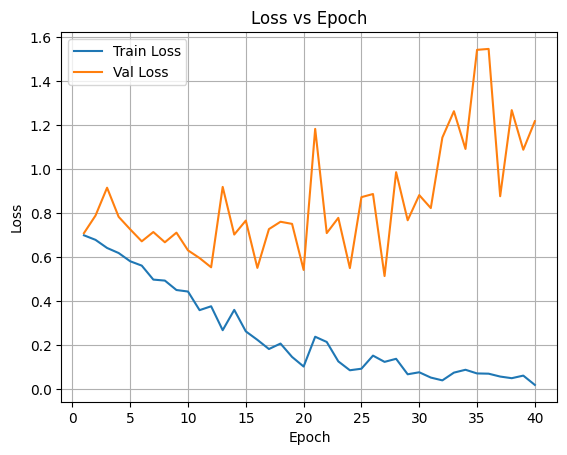

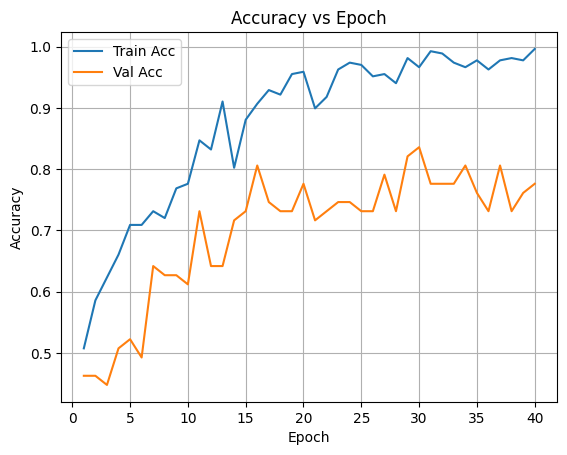

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Loss plot
plt.figure()
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Akurasi plot
plt.figure()
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\krist\AppData\Local\Temp\ipykernel_468492\2923494478.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.stack(data['frames']), torch.tensor(features, dtype=torch.float32), torch.tensor(label, dtype=torch.long), filename


aabyjxwqyo.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
aaeflzzhvy.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
accfrqkrni.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adfzvplbky.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adrqlckutl.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
adsxwxeibr.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
ahencqpiin.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
alzbizkswy.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
aqhbszcpal.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
baqledjaon.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
barbcborgl.pt: Predicted = REAL, True = REAL
bfkzrgovsv.pt: Predicted = FACE-SWAP DEEPFAKE, True = REAL
bfljjbavig.pt: Predicted = REAL, True = FACE-SWAP DEEPFAKE
bhqcqwcise.pt: Predicted = REAL, True = REAL
bqwwkjlmgv.pt: Predicted = FACE-SWAP DEEPFAKE, True = FACE-SWAP DEEPFAKE
chjatzdqcl.pt: Predicted = REAL, True = REAL
chnbexdyhq.pt: Predicted = F

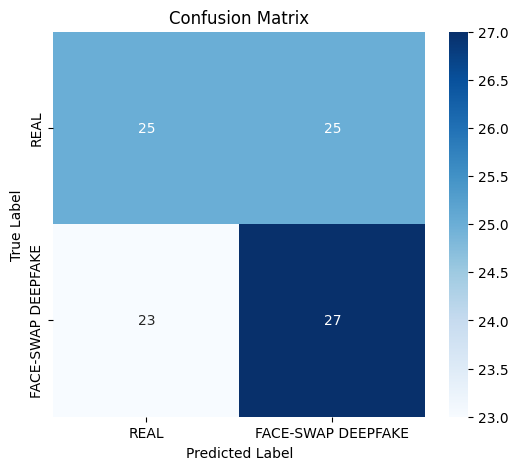


📊 Classification Report:
                    precision    recall  f1-score   support

              REAL       0.52      0.50      0.51        50
FACE-SWAP DEEPFAKE       0.52      0.54      0.53        50

          accuracy                           0.52       100
         macro avg       0.52      0.52      0.52       100
      weighted avg       0.52      0.52      0.52       100


📈 AUC Score: 0.5352


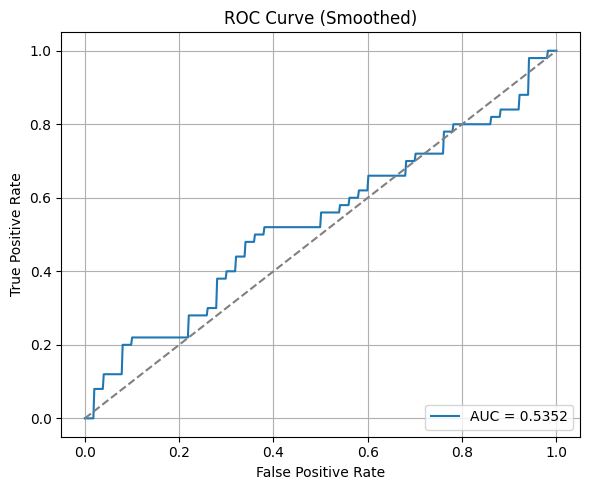

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from scipy.interpolate import interp1d

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
def load_model(weights_path):
    model = DeepfakeDetector()
    model.load_state_dict(torch.load(weights_path, map_location=device))
    model.to(device)
    model.eval()
    return model

# Path konfigurasi
model_path = "Model/Paper-2/MLP-CNN_LR1e-3.pth"
pt_folder = "Dataset Deepfake Preprocessed/Preprocessed Wajah/testing/testing 1080p"
predictor_path = "shape_predictor_68_face_landmarks.dat"

# Load model
model = load_model(model_path)

# Load dataset dan loader
test_dataset = ProcessedLandmarkFeatureDataset(pt_folder, predictor_path, features_mean, features_std)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

classes = ['REAL', 'FACE-SWAP DEEPFAKE']
true_labels = []
predicted_labels = []
probs_class1 = []

# Inference loop
for frames, features, labels, filenames in test_loader:
    frames = frames.to(device)  # (1, T, C, H, W)
    features = features.to(device).float()
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(frames, features).squeeze(1)
        probs = outputs.cpu().numpy()[0]              # scalar
        predicted = int(probs >= 0.5)                 # threshold
        probs_class1.append(probs)                    # DEEPFAKE prob

    true_label = labels.item()
    filename = filenames[0]
    print(f"{filename}: Predicted = {classes[predicted]}, True = {classes[true_label]}")

    true_labels.append(true_label)
    predicted_labels.append(predicted)

# Akurasi
correct = sum(p == t for p, t in zip(predicted_labels, true_labels))
accuracy = correct / len(true_labels) if true_labels else 0
print(f"\n✅ Testing Accuracy: {accuracy * 100:.2f}% ({correct}/{len(true_labels)})")

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\n📊 Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=classes))

# AUC Score & ROC Curve
if len(set(true_labels)) == 2:
    auc_score = roc_auc_score(true_labels, probs_class1)
    print(f"\n📈 AUC Score: {auc_score:.4f}")

    fpr, tpr, _ = roc_curve(true_labels, probs_class1)
    fpr_smooth = np.linspace(0, 1, 500)
    tpr_smooth = interp1d(fpr, tpr, kind='linear', fill_value="extrapolate")(fpr_smooth)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr_smooth, tpr_smooth, label=f"AUC = {auc_score:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Smoothed)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ AUC tidak bisa dihitung karena hanya ada satu kelas di label.")
